# Imports

In [43]:
%matplotlib inline

from utils import (
    create_mmsi_dict_from_file,
    filter_stationary_ships,
    segment_and_renumber,
    haversine_m,
    create_sequences,
    prepare_training_data,
    iterative_predict,
    prepare_delta_sequences,
    iterative_predict_delta,
    plot_ship_trajectory_with_prediction,
)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import random

In [2]:
# PyTorch GPU check
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"\n✅ PyTorch GPU detected!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    DEVICE = torch.device("cuda")
else:
    print("\n❌ No GPU detected for PyTorch. Using CPU.")
    DEVICE = torch.device("cpu")

print(f"\nUsing device: {DEVICE}")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8

✅ PyTorch GPU detected!
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU Memory: 4.0 GB

Using device: cuda


# Fecthing data

In [3]:
file_name = "data/mmsi_type.txt"
mmsi_map = create_mmsi_dict_from_file(file_name)

if mmsi_map:
    print("--- Successfully created dictionary ---")

--- Successfully created dictionary ---


In [4]:
df = pd.read_csv("data/ais_combined_merged.csv")
df_with_types = df.copy()
df_with_types['Type'] = df_with_types['MMSI'].astype(str).map(mmsi_map)
allowed_type = ['Cargo ship', 'Cargo ship (HAZ-A)', 'Cargo ship (HAZ-B)', 'Cargo ship (HAZ-D)', 'Tanker', 'Tanker (HAZ-A)', 'Tanker (HAZ-B)', 'Tanker (HAZ-C)', 'Tanker (HAZ-D)']
df_cargo = df_with_types[df_with_types['Type'].isin(allowed_type)]

df_cargo = df_cargo.drop(columns=["Type"], axis= 1)

df_cargo_filtered = filter_stationary_ships(df_cargo) # This df has dropped stationary ships

Found 6 stationary ships out of 291.
Cleaned DF contains 285 ships.


# Data preprocessing

In [5]:
# Configuration Parameters
GAP_BREAK_MIN = 180
INTERPOLATION_LIMIT_MIN = None
MAX_DISTANCE_M = 3000
MAX_SOG_KNOTS = 40
OUTPUT_PATH = "data/ais_data_5min_clean.csv"
NUM_COLS = ["SOG", "COG", "Longtitude", "Latitude"]
MIN_SEGMENT_LENGTH = 25
INTERVAL = 5

In [6]:
print("="*60)
print("STEP 1: Data Preprocessing")
print("="*60)

# Sort data by MMSI and Timestamp
df_cargo = df_cargo.sort_values(["MMSI", "Timestamp"]).reset_index(drop=True)
df_cargo["Timestamp"] = pd.to_datetime(df_cargo["Timestamp"], errors="coerce")

print(f"Initial data shape: {df_cargo.shape}")
print(f"Data types:\n{df_cargo.dtypes}\n")

# Segment trajectories based on time gaps
print("Segmenting trajectories...")
df = segment_and_renumber(df_cargo, GAP_BREAK_MIN)

# Downsample & interpolate per segment
print(f"Downsampling to {INTERVAL}-minute intervals and interpolating...")
results = []

for (mmsi, seg), g in df.groupby(["MMSI", "Segment"], observed=True):
    g = g.set_index("Timestamp")
    
    # Downsample to 5-minute intervals (keep last observation)
    g1 = g.resample(f"{INTERVAL}min").last()
    
    # Interpolate numeric columns for short gaps only
    g1[NUM_COLS] = g1[NUM_COLS].interpolate(
        method="time", limit=INTERPOLATION_LIMIT_MIN, limit_direction="both"
    )
    
    # Drop rows where ANY of the critical columns are NaN
    g1 = g1.dropna(subset=NUM_COLS, how="any")
    
    # Fill identifiers
    g1["MMSI"] = mmsi
    g1["Segment"] = seg
    
    # Calculate distance and speed between consecutive points
    lat = g1["Latitude"].to_numpy()
    lon = g1["Longtitude"].to_numpy()
    lat_prev, lon_prev = np.roll(lat, 1), np.roll(lon, 1)
    lat_prev[0], lon_prev[0] = lat[0], lon[0]
    
    g1["distance_m"] = haversine_m(lat, lon, lat_prev, lon_prev)
    g1.loc[g1.index[0], "distance_m"] = 0.0
    g1["speed_mps_track"] = g1["distance_m"] / 60.0
    
    # Filter unrealistic movement or SOG
    g1 = g1[(g1["distance_m"] < MAX_DISTANCE_M) & (g1["SOG"] <= MAX_SOG_KNOTS)]
    
    results.append(g1)

# Combine all segments
df_clean = pd.concat(results).reset_index()

STEP 1: Data Preprocessing
Initial data shape: (1737515, 7)
Data types:
MMSI                   int64
SOG                  float64
COG                  float64
Longtitude           float64
Latitude             float64
Timestamp     datetime64[ns]
Segment                int64
dtype: object

Segmenting trajectories...
Initial data shape: (1737515, 7)
Data types:
MMSI                   int64
SOG                  float64
COG                  float64
Longtitude           float64
Latitude             float64
Timestamp     datetime64[ns]
Segment                int64
dtype: object

Segmenting trajectories...
Downsampling to 5-minute intervals and interpolating...
Downsampling to 5-minute intervals and interpolating...


In [7]:
print("="*60)
print("STEP 2: Data Quality Check")
print("="*60)
print(f"Rows before cleaning: {len(df_clean)}")

# Check for missing data
missing = df_clean[df_clean[["SOG", "COG", "Latitude", "Longtitude"]].isna().any(axis=1)]
print(f"Rows with missing numeric data: {len(missing)} ({len(missing)/len(df_clean)*100:.2f}%)")
print(f"MMSI with missing data: {missing['MMSI'].nunique()}")

# Remove rows with missing critical data
df_clean = df_clean.dropna(subset=["SOG", "COG", "Latitude", "Longtitude", "MMSI", "Segment"])
print(f"Rows after cleaning: {len(df_clean)}")

# Verify time gaps before re-segmentation
max_gap = df_clean.groupby(["MMSI","Segment"])["Timestamp"].diff().dt.total_seconds().div(60).max()
print(f"Maximum time gap before re-segmentation: {max_gap:.2f} minutes")

# Re-segment based on time gaps created by filtering (gaps > INTERVAL min = new segment)
print(f"\nRe-segmenting based on gaps > {INTERVAL} minutes...")
df_clean = df_clean.sort_values(["MMSI", "Segment", "Timestamp"]).reset_index(drop=True)
df_clean["time_gap"] = df_clean.groupby(["MMSI", "Segment"])["Timestamp"].diff().dt.total_seconds().div(60)
df_clean["new_seg"] = (df_clean["time_gap"] > INTERVAL) | (df_clean["time_gap"].isna())
df_clean["Segment"] = df_clean.groupby("MMSI")["new_seg"].cumsum()
df_clean = df_clean.drop(columns=["time_gap", "new_seg"])

# Verify time gaps after re-segmentation
max_gap_after = df_clean.groupby(["MMSI","Segment"])["Timestamp"].diff().dt.total_seconds().div(60).max()
print(f"Maximum time gap after re-segmentation: {max_gap_after:.2f} minutes")
has_large_gaps = (df_clean.groupby(["MMSI","Segment"])["Timestamp"]
                  .diff().dt.total_seconds().div(60).max() > INTERVAL).any()
print(f"Has gaps > {INTERVAL} minutes: {has_large_gaps}")

STEP 2: Data Quality Check
Rows before cleaning: 72355
Rows with missing numeric data: 0 (0.00%)
MMSI with missing data: 0
Rows after cleaning: 72355
Maximum time gap before re-segmentation: 250.00 minutes

Re-segmenting based on gaps > 5 minutes...
Maximum time gap after re-segmentation: 5.00 minutes
Has gaps > 5 minutes: False


In [8]:
print("="*60)
print("STEP 3: Segment Length Filtering")
print("="*60)
# Filter out short segments
print(f"\nFiltering segments with < {MIN_SEGMENT_LENGTH} points...")
print(f"Segments before filtering: {df_clean.groupby(['MMSI', 'Segment']).ngroups}")
print(f"Rows before filtering: {len(df_clean)}")

segment_sizes = df_clean.groupby(["MMSI", "Segment"]).size()
valid_segments = segment_sizes[segment_sizes >= MIN_SEGMENT_LENGTH].index
df_clean = df_clean.set_index(["MMSI", "Segment"]).loc[valid_segments].reset_index()

print(f"Segments after filtering: {df_clean.groupby(['MMSI', 'Segment']).ngroups}")
print(f"Rows after filtering: {len(df_clean)}")

STEP 3: Segment Length Filtering

Filtering segments with < 25 points...
Segments before filtering: 539
Rows before filtering: 72355
Segments after filtering: 341
Rows after filtering: 71321
Segments after filtering: 341
Rows after filtering: 71321


In [9]:
print("\n" + "="*60)
print("STEP 4: Final Dataset Summary")
print("="*60)
print(f"Total rows: {len(df_clean)}")
print(f"Unique vessels (MMSI): {df_clean['MMSI'].nunique()}")
print(f"Total segments: {df_clean.groupby(['MMSI', 'Segment']).ngroups}")
print(f"Average segment length: {df_clean.groupby(['MMSI', 'Segment']).size().mean()*INTERVAL:.1f} minutes")
print(f"Columns: {list(df_clean.columns)}")

# Save cleaned data
df_clean.to_csv(OUTPUT_PATH, index=False)
print(f"\nCleaned data saved to: {OUTPUT_PATH}")



STEP 4: Final Dataset Summary
Total rows: 71321
Unique vessels (MMSI): 283
Total segments: 341
Average segment length: 1045.8 minutes
Columns: ['MMSI', 'Segment', 'Timestamp', 'SOG', 'COG', 'Longtitude', 'Latitude', 'distance_m', 'speed_mps_track']

Cleaned data saved to: data/ais_data_5min_clean.csv

Cleaned data saved to: data/ais_data_5min_clean.csv


# Preparing Dataset

In [18]:
# Configuration for model training
SEQUENCE_LENGTH = 20
# Original features
ORIGINAL_FEATURES = ["Latitude", "Longtitude", "SOG", "COG"]
# Features after delta transformation
FEATURES = ["delta_Lat", "delta_Lon", "SOG", "COG"] 
TARGET_FEATURES = ["delta_Lat", "delta_Lon", "SOG", "COG"]
MIN_SEGMENT_LENGTH = SEQUENCE_LENGTH + 5

print(f"This means the model predicts CHANGES in position rather than absolute positions.")

This means the model predicts CHANGES in position rather than absolute positions.


In [19]:
# Prepare sequences with DELTA coordinates
df_delta = df_clean.copy()

# Compute deltas within each segment
df_delta['delta_Lat'] = df_delta.groupby(['MMSI', 'Segment'])['Latitude'].diff()
df_delta['delta_Lon'] = df_delta.groupby(['MMSI', 'Segment'])['Longtitude'].diff()

# First row of each segment will have NaN deltas - drop them
df_delta = df_delta.dropna(subset=['delta_Lat', 'delta_Lon'])

print(f"Data shape after computing deltas: {df_delta.shape}")
print(f"\nDelta statistics:")
print(f"  delta_Lat - mean: {df_delta['delta_Lat'].mean():.6f}, std: {df_delta['delta_Lat'].std():.6f}")
print(f"  delta_Lon - mean: {df_delta['delta_Lon'].mean():.6f}, std: {df_delta['delta_Lon'].std():.6f}")
print(f"  delta_Lat range: [{df_delta['delta_Lat'].min():.6f}, {df_delta['delta_Lat'].max():.6f}]")
print(f"  delta_Lon range: [{df_delta['delta_Lon'].min():.6f}, {df_delta['delta_Lon'].max():.6f}]")

Data shape after computing deltas: (70980, 11)

Delta statistics:
  delta_Lat - mean: -0.000023, std: 0.008416
  delta_Lon - mean: 0.001439, std: 0.016846
  delta_Lat range: [-0.026041, 0.026717]
  delta_Lon range: [-0.049885, 0.050367]


In [21]:
# Prepare sequences using delta features
X, y, segment_info = prepare_delta_sequences(
    df_delta,
    SEQUENCE_LENGTH,
    FEATURES,
    TARGET_FEATURES,
    MIN_SEGMENT_LENGTH
)

print(f"\nTotal sequences created: {len(X)}")
print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Segments used: {len(set((s['mmsi'], s['segment']) for s in segment_info))}")
print(f"Average sequences per segment: {len(X) / len(set((s['mmsi'], s['segment']) for s in segment_info)):.1f}")

# Store original coordinates for later reconstruction
print("\nStoring original coordinates for reconstruction...")
original_positions = []  # Last known absolute position for each sequence

for (mmsi, seg), group in df_delta.groupby(['MMSI', 'Segment']):
    if len(group) < MIN_SEGMENT_LENGTH:
        continue
    
    lats = group['Latitude'].values
    lons = group['Longtitude'].values
    
    for i in range(len(group) - SEQUENCE_LENGTH):
        # Store the absolute position at the END of each input sequence
        original_positions.append({
            'last_lat': lats[i + SEQUENCE_LENGTH - 1],
            'last_lon': lons[i + SEQUENCE_LENGTH - 1],
            'target_lat': lats[i + SEQUENCE_LENGTH],  # Actual next position
            'target_lon': lons[i + SEQUENCE_LENGTH]
        })

original_positions = pd.DataFrame(original_positions)
print(f"Original positions stored: {len(original_positions)}")


Total sequences created: 64156
Input shape: (64156, 20, 4)
Target shape: (64156, 4)
Segments used: 340
Average sequences per segment: 188.7

Storing original coordinates for reconstruction...
Original positions stored: 64156


In [22]:
# Split data by ships (MMSI)
print("="*60)
print("Splitting Data by Ships (MMSI)")
print("="*60)

# Get unique MMSIs from segment_info
unique_mmsis = list(set([seg['mmsi'] for seg in segment_info]))
n_ships = len(unique_mmsis)

print(f"Total unique ships: {n_ships}")

# Split ships into train (64%), val (16%), test (20%)
mmsi_temp, mmsi_test = train_test_split(
    unique_mmsis, test_size=0.2, random_state=42, shuffle=True
)

mmsi_train, mmsi_val = train_test_split(
    mmsi_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nShips in training set: {len(mmsi_train)} ({len(mmsi_train)/n_ships*100:.1f}%)")
print(f"Ships in validation set: {len(mmsi_val)} ({len(mmsi_val)/n_ships*100:.1f}%)")
print(f"Ships in test set: {len(mmsi_test)} ({len(mmsi_test)/n_ships*100:.1f}%)")

# Create sets of MMSIs for fast lookup
mmsi_train_set = set(mmsi_train)
mmsi_val_set = set(mmsi_val)
mmsi_test_set = set(mmsi_test)

# Split sequences based on which ship they belong to
train_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_train_set]
val_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_val_set]
test_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_test_set]

# Get the actual sequences for each set (RAW)
X_train_raw = X[train_indices]
y_train_raw = y[train_indices]

X_val_raw = X[val_indices]
y_val_raw = y[val_indices]

X_test_raw = X[test_indices]
y_test_raw = y[test_indices]

# Also split original positions for test set reconstruction
original_positions_test = original_positions.iloc[test_indices].reset_index(drop=True)

print(f"\nSequences in training set: {X_train_raw.shape[0]} ({X_train_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Sequences in validation set: {X_val_raw.shape[0]} ({X_val_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Sequences in test set: {X_test_raw.shape[0]} ({X_test_raw.shape[0]/X.shape[0]*100:.1f}%)")

Splitting Data by Ships (MMSI)
Total unique ships: 283

Ships in training set: 180 (63.6%)
Ships in validation set: 46 (16.3%)
Ships in test set: 57 (20.1%)

Sequences in training set: 41287 (64.4%)
Sequences in validation set: 10387 (16.2%)
Sequences in test set: 12482 (19.5%)


In [25]:
# Normalize the data
print("="*60)
print("Normalizing Data")
print("="*60)

# Reshape X_train for normalization
n_samples_train, n_timesteps, n_features = X_train_raw.shape
X_train_reshaped = X_train_raw.reshape(-1, n_features)

# Fit scaler on training data
scaler_X = StandardScaler()
X_train_normalized_reshaped = scaler_X.fit_transform(X_train_reshaped)
X_train = X_train_normalized_reshaped.reshape(n_samples_train, n_timesteps, n_features)

# Transform val and test
X_val_reshaped = X_val_raw.reshape(-1, n_features)
X_val = scaler_X.transform(X_val_reshaped).reshape(X_val_raw.shape[0], n_timesteps, n_features)

X_test_reshaped = X_test_raw.reshape(-1, n_features)
X_test = scaler_X.transform(X_test_reshaped).reshape(X_test_raw.shape[0], n_timesteps, n_features)

# Normalize targets
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

print(f"Input data normalized")
print(f"Target data normalized")
print(f"\nFeature means: {scaler_X.mean_}")
print(f"Feature stds: {scaler_X.scale_}")
print(f"\nTarget means: {scaler_y.mean_}")
print(f"Target stds: {scaler_y.scale_}")

Normalizing Data
Input data normalized
Target data normalized

Feature means: [2.23316601e-04 2.28750452e-04 3.85229086e+00 1.77588234e+02]
Feature stds: [8.50317623e-03 1.70150662e-02 2.75247679e+00 1.06508189e+02]

Target means: [2.05569761e-04 3.00704016e-04 3.82585669e+00 1.77497506e+02]
Target stds: [8.41489838e-03 1.70192872e-02 2.76048494e+00 1.06373329e+02]
Input data normalized
Target data normalized

Feature means: [2.23316601e-04 2.28750452e-04 3.85229086e+00 1.77588234e+02]
Feature stds: [8.50317623e-03 1.70150662e-02 2.75247679e+00 1.06508189e+02]

Target means: [2.05569761e-04 3.00704016e-04 3.82585669e+00 1.77497506e+02]
Target stds: [8.41489838e-03 1.70192872e-02 2.76048494e+00 1.06373329e+02]


# Convert to Pytorch

In [26]:
# Convert to PyTorch tensors and move to device
print("\n" + "="*60)
print("Converting to PyTorch Tensors")
print("="*60)

X_train_tensor = torch.FloatTensor(X_train).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train).to(DEVICE)
X_val_tensor = torch.FloatTensor(X_val).to(DEVICE)
y_val_tensor = torch.FloatTensor(y_val).to(DEVICE)
X_test_tensor = torch.FloatTensor(X_test).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test).to(DEVICE)

# Create DataLoaders
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Data moved to: {DEVICE}")


Converting to PyTorch Tensors
Training batches: 646
Validation batches: 163
Test batches: 196
Data moved to: cuda


# GRU model

In [27]:
class GRUModel(nn.Module):
    """
    PyTorch GRU model for trajectory prediction.
    """
    def __init__(self, n_features, n_outputs, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(GRUModel, self).__init__()
        
        # GRU layers
        self.gru1 = nn.GRU(n_features, hidden_sizes[0], batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.dropout1 = nn.Dropout(dropout)
        
        self.gru2 = nn.GRU(hidden_sizes[0], hidden_sizes[1], batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout)
        
        self.gru3 = nn.GRU(hidden_sizes[1], hidden_sizes[2], batch_first=True)
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout3 = nn.Dropout(0.2)
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_sizes[2], 64)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout5 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(32, n_outputs)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # GRU layer 1
        out, _ = self.gru1(x)
        out = self.bn1(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.dropout1(out)
        
        # GRU layer 2
        out, _ = self.gru2(out)
        out = self.bn2(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.dropout2(out)
        
        # GRU layer 3 (take last output)
        out, _ = self.gru3(out)
        out = out[:, -1, :]  # Take last timestep
        out = self.bn3(out)
        out = self.dropout3(out)
        
        # Dense layers
        out = self.relu(self.fc1(out))
        out = self.dropout4(out)
        out = self.relu(self.fc2(out))
        out = self.dropout5(out)
        out = self.fc3(out)
        
        return out


# Build the model
print("="*60)
print("Building PyTorch GRU Model")
print("="*60)

model = GRUModel(
    n_features=len(FEATURES),
    n_outputs=len(TARGET_FEATURES)
).to(DEVICE)

# Display model architecture
print(model)
print(f"\nModel moved to: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Building PyTorch GRU Model
GRUModel(
  (gru1): GRU(4, 128, batch_first=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (gru2): GRU(128, 64, batch_first=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (gru3): GRU(64, 32, batch_first=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout5): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)

Model moved to: cuda
Total parameters: 102,884
Trainable parameters: 102,884


In [28]:
# Setup training components
print("="*60)
print("Setting up Training Components")
print("="*60)

# Create output directory - use different folder for delta model
OUTPUT_DIR = "models/GRU_delta"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

# Loss function (Huber Loss / Smooth L1)
criterion = nn.SmoothL1Loss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (similar to ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

print("Training components configured:")
print("  - Loss: Smooth L1 (Huber)")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print("  - Early Stopping: patience=30")

Setting up Training Components
Output directory: models/GRU_delta
Training components configured:
  - Loss: Smooth L1 (Huber)
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Early Stopping: patience=15
Training components configured:
  - Loss: Smooth L1 (Huber)
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Early Stopping: patience=15


In [29]:
# Training loop
print("="*60)
print("Training PyTorch GRU Model")
print("="*60)

EPOCHS = 1000
PATIENCE = 15

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'lr': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        # Save best model
        torch.save(best_model_state, f'{OUTPUT_DIR}/best_gru_model.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - lr: {current_lr:.6f} ✓ saved")
    else:
        patience_counter += 1
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - lr: {current_lr:.6f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

# Save final model and history
torch.save(model.state_dict(), f'{OUTPUT_DIR}/final_gru_model.pth')
with open(f'{OUTPUT_DIR}/training_history.json', 'w') as f:
    json.dump(history, f)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

Training PyTorch GRU Model
Epoch 1/1000 - loss: 0.0909 - mae: 0.3051 - val_loss: 0.0504 - val_mae: 0.1540 - lr: 0.001000 ✓ saved
Epoch 1/1000 - loss: 0.0909 - mae: 0.3051 - val_loss: 0.0504 - val_mae: 0.1540 - lr: 0.001000 ✓ saved
Epoch 2/1000 - loss: 0.0640 - mae: 0.2487 - val_loss: 0.0493 - val_mae: 0.1521 - lr: 0.001000 ✓ saved
Epoch 2/1000 - loss: 0.0640 - mae: 0.2487 - val_loss: 0.0493 - val_mae: 0.1521 - lr: 0.001000 ✓ saved
Epoch 3/1000 - loss: 0.0587 - mae: 0.2339 - val_loss: 0.0484 - val_mae: 0.1467 - lr: 0.001000 ✓ saved
Epoch 3/1000 - loss: 0.0587 - mae: 0.2339 - val_loss: 0.0484 - val_mae: 0.1467 - lr: 0.001000 ✓ saved
Epoch 4/1000 - loss: 0.0552 - mae: 0.2227 - val_loss: 0.0484 - val_mae: 0.1496 - lr: 0.001000 ✓ saved
Epoch 4/1000 - loss: 0.0552 - mae: 0.2227 - val_loss: 0.0484 - val_mae: 0.1496 - lr: 0.001000 ✓ saved
Epoch 5/1000 - loss: 0.0528 - mae: 0.2153 - val_loss: 0.0480 - val_mae: 0.1488 - lr: 0.001000 ✓ saved
Epoch 5/1000 - loss: 0.0528 - mae: 0.2153 - val_loss: 0

Training History


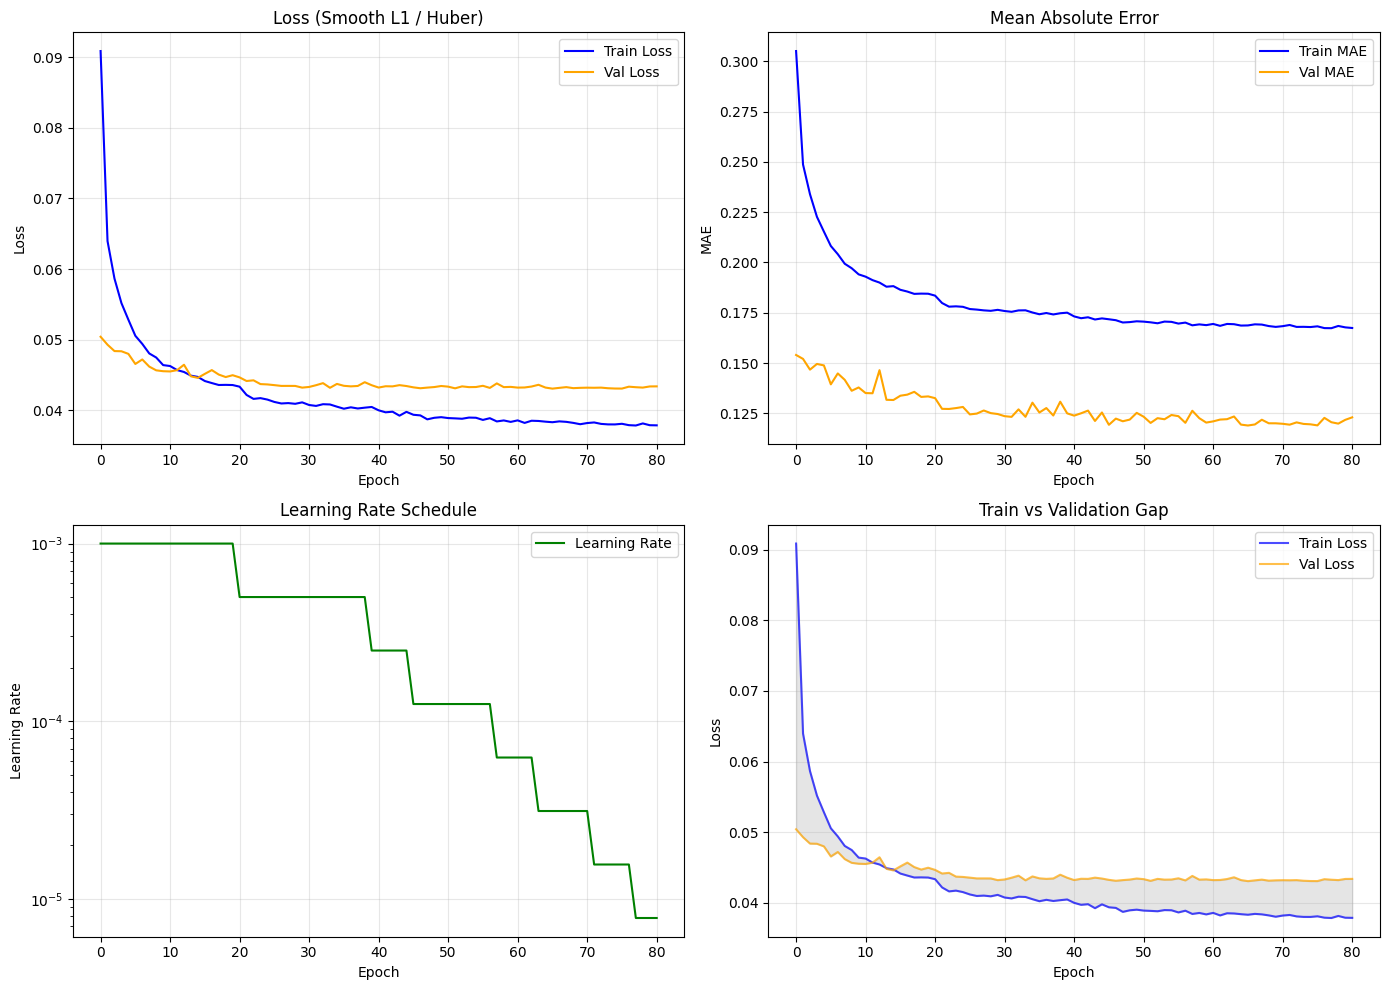


Training Summary:
  Total epochs: 81
  Best val_loss: 0.0431 (epoch 66)
  Final train_loss: 0.0379
  Final val_loss: 0.0434
  Final train_mae: 0.1674
  Final val_mae: 0.1230

Plot saved to: models/GRU_delta/plots/training_history.png


In [30]:
# Plot training history
print("="*60)
print("Training History")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Loss (Smooth L1 / Huber)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Train vs Val Loss comparison
axes[1, 1].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[1, 1].plot(history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
axes[1, 1].fill_between(range(len(history['train_loss'])), 
                         history['train_loss'], history['val_loss'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_title('Train vs Validation Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/training_history.png', dpi=150)
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best val_loss: {min(history['val_loss']):.4f} (epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
print(f"  Final train_mae: {history['train_mae'][-1]:.4f}")
print(f"  Final val_mae: {history['val_mae'][-1]:.4f}")
print(f"\nPlot saved to: {OUTPUT_DIR}/plots/training_history.png")

# Evaluation on test set

In [31]:
# Evaluate on Test Set (with DELTA to absolute conversion)
print("="*60)
print("Evaluating Best Model on Test Set (Delta Model)")
print("="*60)

# Load best model
model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_gru_model.pth'))
model.eval()

# Collect all predictions and targets
all_preds = []
all_targets = []
test_loss = 0.0
test_mae = 0.0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_mae /= len(test_loader)

# Concatenate all predictions and targets (normalized deltas)
y_pred_normalized = np.concatenate(all_preds, axis=0)
y_true_normalized = np.concatenate(all_targets, axis=0)

# Inverse transform to original scale (still deltas)
y_pred_delta = scaler_y.inverse_transform(y_pred_normalized)
y_true_delta = scaler_y.inverse_transform(y_true_normalized)

# Convert deltas back to absolute positions
# pred_abs = last_known_position + predicted_delta
last_lats = original_positions_test['last_lat'].values
last_lons = original_positions_test['last_lon'].values
target_lats = original_positions_test['target_lat'].values
target_lons = original_positions_test['target_lon'].values

# Predicted absolute positions
pred_lat_abs = last_lats + y_pred_delta[:, 0]  # last_lat + delta_lat
pred_lon_abs = last_lons + y_pred_delta[:, 1]  # last_lon + delta_lon
pred_sog = y_pred_delta[:, 2]
pred_cog = y_pred_delta[:, 3]

# True absolute positions (from stored data)
true_lat_abs = target_lats
true_lon_abs = target_lons
true_sog = y_true_delta[:, 2]
true_cog = y_true_delta[:, 3]

# Calculate metrics for each feature
print(f"\n{'Feature':<15} {'MAE':>12} {'RMSE':>12} {'R²':>10}")
print("-" * 50)

# Latitude (absolute)
lat_mae = np.mean(np.abs(pred_lat_abs - true_lat_abs))
lat_rmse = np.sqrt(np.mean((pred_lat_abs - true_lat_abs)**2))
ss_res = np.sum((true_lat_abs - pred_lat_abs)**2)
ss_tot = np.sum((true_lat_abs - np.mean(true_lat_abs))**2)
lat_r2 = 1 - (ss_res / ss_tot)
print(f"{'Latitude':<15} {lat_mae:>12.6f} {lat_rmse:>12.6f} {lat_r2:>10.4f}")

# Longitude (absolute)
lon_mae = np.mean(np.abs(pred_lon_abs - true_lon_abs))
lon_rmse = np.sqrt(np.mean((pred_lon_abs - true_lon_abs)**2))
ss_res = np.sum((true_lon_abs - pred_lon_abs)**2)
ss_tot = np.sum((true_lon_abs - np.mean(true_lon_abs))**2)
lon_r2 = 1 - (ss_res / ss_tot)
print(f"{'Longtitude':<15} {lon_mae:>12.6f} {lon_rmse:>12.6f} {lon_r2:>10.4f}")

# SOG
sog_mae = np.mean(np.abs(pred_sog - true_sog))
sog_rmse = np.sqrt(np.mean((pred_sog - true_sog)**2))
ss_res = np.sum((true_sog - pred_sog)**2)
ss_tot = np.sum((true_sog - np.mean(true_sog))**2)
sog_r2 = 1 - (ss_res / ss_tot)
print(f"{'SOG':<15} {sog_mae:>12.6f} {sog_rmse:>12.6f} {sog_r2:>10.4f}")

# COG
cog_mae = np.mean(np.abs(pred_cog - true_cog))
cog_rmse = np.sqrt(np.mean((pred_cog - true_cog)**2))
ss_res = np.sum((true_cog - pred_cog)**2)
ss_tot = np.sum((true_cog - np.mean(true_cog))**2)
cog_r2 = 1 - (ss_res / ss_tot)
print(f"{'COG':<15} {cog_mae:>12.6f} {cog_rmse:>12.6f} {cog_r2:>10.4f}")

print("-" * 50)

# Calculate distance error (using Haversine for Lat/Long)
distance_errors = haversine_m(pred_lat_abs, pred_lon_abs, true_lat_abs, true_lon_abs)

print(f"\n{'='*60}")
print("Distance Error Statistics (meters)")
print("="*60)
print(f"Mean distance error:   {np.mean(distance_errors):>10.2f} m")
print(f"Median distance error: {np.median(distance_errors):>10.2f} m")
print(f"Std distance error:    {np.std(distance_errors):>10.2f} m")
print(f"Min distance error:    {np.min(distance_errors):>10.2f} m")
print(f"Max distance error:    {np.max(distance_errors):>10.2f} m")
print(f"90th percentile:       {np.percentile(distance_errors, 90):>10.2f} m")
print(f"95th percentile:       {np.percentile(distance_errors, 95):>10.2f} m")
print(f"99th percentile:       {np.percentile(distance_errors, 99):>10.2f} m")

# Summary
print(f"\n{'='*60}")
print("Test Set Summary (Delta Model)")
print("="*60)
print(f"Test samples:      {len(true_lat_abs)}")
print(f"Test Loss (Huber): {test_loss:.6f}")
print(f"Test MAE (norm):   {test_mae:.6f}")

# Save test metrics
test_metrics = {
    'model_type': 'delta_coordinates',
    'test_loss': test_loss,
    'test_mae_normalized': test_mae,
    'distance_error_mean_m': float(np.mean(distance_errors)),
    'distance_error_median_m': float(np.median(distance_errors)),
    'distance_error_std_m': float(np.std(distance_errors)),
    'distance_error_90th_m': float(np.percentile(distance_errors, 90)),
    'distance_error_95th_m': float(np.percentile(distance_errors, 95)),
    'per_feature_metrics': {
        'Latitude': {'MAE': float(lat_mae), 'RMSE': float(lat_rmse), 'R2': float(lat_r2)},
        'Longtitude': {'MAE': float(lon_mae), 'RMSE': float(lon_rmse), 'R2': float(lon_r2)},
        'SOG': {'MAE': float(sog_mae), 'RMSE': float(sog_rmse), 'R2': float(sog_r2)},
        'COG': {'MAE': float(cog_mae), 'RMSE': float(cog_rmse), 'R2': float(cog_r2)}
    }
}

with open(f'{OUTPUT_DIR}/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=2)

print(f"\nTest metrics saved to: {OUTPUT_DIR}/test_metrics.json")

Evaluating Best Model on Test Set (Delta Model)

Feature                  MAE         RMSE         R²
--------------------------------------------------
Latitude            0.000547     0.000997     1.0000
Longtitude          0.000929     0.001892     1.0000
SOG                 0.147988     0.345528     0.9858
COG                15.238972    41.160477     0.8315
--------------------------------------------------

Distance Error Statistics (meters)
Mean distance error:        93.43 m
Median distance error:      53.16 m
Std distance error:        132.65 m
Min distance error:          0.91 m
Max distance error:       2310.97 m
90th percentile:           190.59 m
95th percentile:           302.95 m
99th percentile:           675.26 m

Test Set Summary (Delta Model)
Test samples:      12482
Test Loss (Huber): 0.019490
Test MAE (norm):   0.079342

Test metrics saved to: models/GRU_delta/test_metrics.json

Feature                  MAE         RMSE         R²
----------------------------------

In [32]:
# Additional Analysis: Error Context
print("="*60)
print("Error Analysis in Context")  
print("="*60)

print(f"\nError Distribution:")
print(f"  < 50m:   {np.sum(distance_errors < 50):>6} ({np.sum(distance_errors < 50)/len(distance_errors)*100:.1f}%)")
print(f"  < 100m:  {np.sum(distance_errors < 100):>6} ({np.sum(distance_errors < 100)/len(distance_errors)*100:.1f}%)")
print(f"  < 200m:  {np.sum(distance_errors < 200):>6} ({np.sum(distance_errors < 200)/len(distance_errors)*100:.1f}%)")
print(f"  < 500m:  {np.sum(distance_errors < 500):>6} ({np.sum(distance_errors < 500)/len(distance_errors)*100:.1f}%)")
print(f"  >= 500m: {np.sum(distance_errors >= 500):>6} ({np.sum(distance_errors >= 500)/len(distance_errors)*100:.1f}%)")

# Reference: typical ship movement
avg_movement = np.sqrt((np.mean(np.abs(y_true_delta[:, 0]))*111000)**2 + 
                        (np.mean(np.abs(y_true_delta[:, 1]))*111000*0.6)**2)
avg_sog = np.mean(np.abs(y_true_delta[:, 2]))
expected_5min = avg_sog * 1852 / 12  # knots to m/5min

print(f"\nContext - Ship Movement in 5 minutes:")
print(f"  Average SOG: {avg_sog:.2f} knots")
print(f"  Expected movement: ~{expected_5min:.0f} m")
print(f"  Mean error: {np.mean(distance_errors):.2f} m")
print(f"  Relative error: {np.mean(distance_errors)/expected_5min*100:.1f}%")

print(f"\n✅ The Delta Coordinate model achieves {np.mean(distance_errors):.0f}m error")
print(f"   for 5-minute predictions where ships move ~{expected_5min:.0f}m")
print(f"   This is {np.mean(distance_errors)/expected_5min*100:.1f}% relative error - quite good!")

Error Analysis in Context

Error Distribution:
  < 50m:     6044 (48.4%)
  < 100m:    9015 (72.2%)
  < 200m:   11322 (90.7%)
  < 500m:   12209 (97.8%)
  >= 500m:    273 (2.2%)

Context - Ship Movement in 5 minutes:
  Average SOG: 3.66 knots
  Expected movement: ~565 m
  Mean error: 93.43 m
  Relative error: 16.5%

✅ The Delta Coordinate model achieves 93m error
   for 5-minute predictions where ships move ~565m
   This is 16.5% relative error - quite good!


In [33]:
# Multi-Step Iterative Prediction with DELTA coordinates (50 minutes = 10 steps × 5 min)
print("="*60)
print("Multi-Step Iterative Prediction (Delta Model - 50 minutes ahead)")
print("="*60)

PREDICTION_STEPS = 10  # 10 steps × 5 minutes = 50 minutes
model.eval()

# Perform iterative predictions on test set
print(f"\nPredicting {PREDICTION_STEPS} steps ({PREDICTION_STEPS * INTERVAL} minutes) ahead...")
print(f"Using {len(X_test)} test sequences\n")

# Store results
all_iterative_preds_abs = []  # Absolute positions
all_iterative_preds_delta = []  # Delta values

for i in tqdm(range(len(X_test)), desc="Iterative Predictions"):
    # Get normalized input sequence
    input_seq = X_test[i]
    
    # Get last known absolute position
    last_lat = original_positions_test.iloc[i]['last_lat']
    last_lon = original_positions_test.iloc[i]['last_lon']
    
    # Perform iterative prediction
    preds_abs, preds_delta = iterative_predict_delta(
        model, input_seq, PREDICTION_STEPS, scaler_X, scaler_y, DEVICE,
        last_lat, last_lon
    )
    all_iterative_preds_abs.append(preds_abs)
    all_iterative_preds_delta.append(preds_delta)

all_iterative_preds_abs = np.array(all_iterative_preds_abs)
all_iterative_preds_delta = np.array(all_iterative_preds_delta)

print(f"\nIterative predictions shape: {all_iterative_preds_abs.shape}")
print(f"  - {all_iterative_preds_abs.shape[0]} test sequences")
print(f"  - {all_iterative_preds_abs.shape[1]} prediction steps")
print(f"  - {all_iterative_preds_abs.shape[2]} features (lat, lon, sog, cog)")

Multi-Step Iterative Prediction (Delta Model - 50 minutes ahead)

Predicting 10 steps (50 minutes) ahead...
Using 12482 test sequences



Iterative Predictions: 100%|██████████| 12482/12482 [07:57<00:00, 26.12it/s]


Iterative predictions shape: (12482, 10, 4)
  - 12482 test sequences
  - 10 prediction steps
  - 4 features (lat, lon, sog, cog)


Analyzing Error Accumulation Across Prediction Horizons (Delta Model)
Sequences with at least 1 future ground truth: 12409

Step         Time    Samples     Mean (m)   Median (m)      Std (m)
----------------------------------------------------------------------
1            5 min      12482        93.43        53.13       132.65
2           10 min      12409       231.62       130.07       325.09
3           15 min      12336       406.36       224.88       572.98
4           20 min      12263       608.42       329.51       862.39
5           25 min      12190       833.74       445.10      1186.19
6           30 min      12117      1079.37       564.09      1536.61
7           35 min      12046      1341.95       694.83      1901.92
8           40 min      11975      1621.50       825.15      2287.52
9           45 min      11904      1912.86       962.82      2680.74
10          50 min      11833      2218.21      1109.43      3091.11


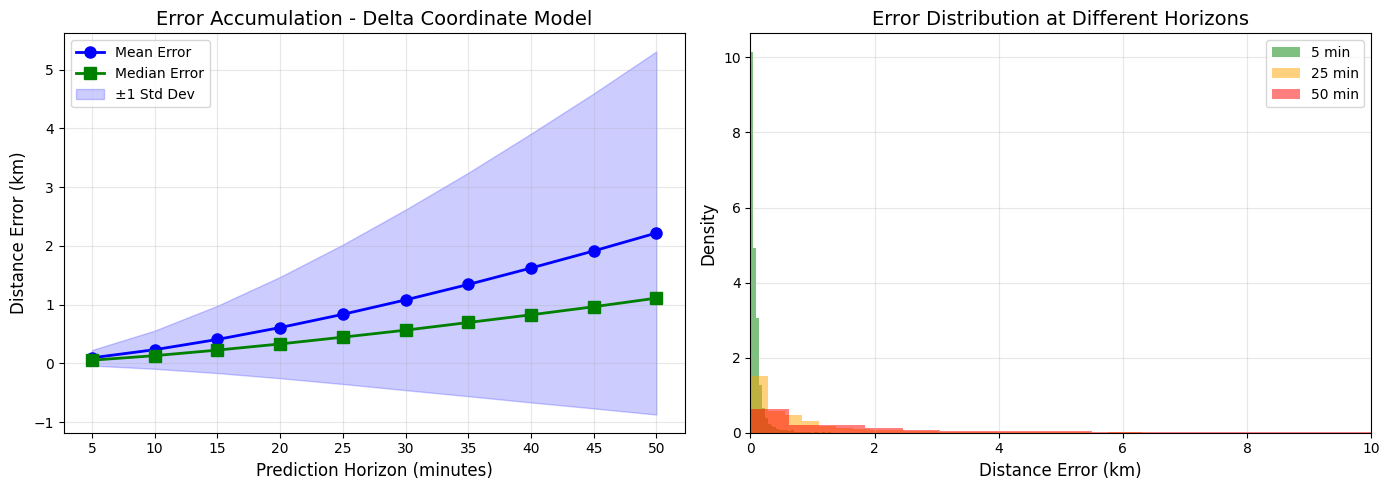


Multi-Step Prediction Summary (Delta Model)
Prediction horizon: 50 minutes (10 steps)

At 5 min:  Mean = 93 m, Median = 53 m
At 25 min: Mean = 834 m, Median = 445 m
At 50 min: Mean = 2218 m, Median = 1109 m

Plot saved to: models/GRU_delta/plots/multi_step_error_analysis.png
Metrics saved to: models/GRU_delta/multi_step_metrics.json


In [34]:
# Analyze Error Accumulation Across Prediction Steps (Delta Model) - FIXED
print("="*60)
print("Analyzing Error Accumulation Across Prediction Horizons (Delta Model)")
print("="*60)

from collections import defaultdict

# Build mapping of test sequences to their ground truth future values
segment_to_indices = defaultdict(list)
for idx, orig_idx in enumerate(test_indices):
    seg_info = segment_info[orig_idx]
    key = (seg_info['mmsi'], seg_info['segment'])
    segment_to_indices[key].append((idx, orig_idx))

# For sequences with consecutive ground truth, compute multi-step errors
step_errors = {step: [] for step in range(PREDICTION_STEPS)}
sequences_with_gt = 0

for key, indices in segment_to_indices.items():
    # Sort by original index to ensure temporal order
    indices_sorted = sorted(indices, key=lambda x: x[1])
    
    for i, (test_idx, orig_idx) in enumerate(indices_sorted):
        # For step N prediction, we need ground truth N steps ahead
        # Step 1: compare with current sequence's target (t+1)
        # Step 2: compare with next sequence's target (t+2)
        # etc.
        
        # Step 0 (first prediction) compares with current sequence's target
        preds = all_iterative_preds_abs[test_idx]  # (n_steps, 4)
        
        # Step 0: compare with THIS sequence's target
        gt_lat_step0 = original_positions_test.iloc[test_idx]['target_lat']
        gt_lon_step0 = original_positions_test.iloc[test_idx]['target_lon']
        dist_error_step0 = haversine_m(preds[0, 0], preds[0, 1], gt_lat_step0, gt_lon_step0)
        step_errors[0].append(dist_error_step0)
        
        # For steps 1+, we need future sequences' targets
        available_future = len(indices_sorted) - i - 1
        
        if available_future > 0:
            sequences_with_gt += 1
            
            # Step N (N>=1): compare with sequence[i+N]'s target
            for step in range(1, min(PREDICTION_STEPS, available_future + 1)):
                future_test_idx = indices_sorted[i + step][0]
                
                # Ground truth absolute position
                gt_lat = original_positions_test.iloc[future_test_idx]['target_lat']
                gt_lon = original_positions_test.iloc[future_test_idx]['target_lon']
                
                # Predicted absolute position
                pred_lat = preds[step, 0]
                pred_lon = preds[step, 1]
                
                # Calculate distance error
                dist_error = haversine_m(pred_lat, pred_lon, gt_lat, gt_lon)
                step_errors[step].append(dist_error)

print(f"Sequences with at least 1 future ground truth: {sequences_with_gt}")
print(f"\n{'Step':<6} {'Time':>10} {'Samples':>10} {'Mean (m)':>12} {'Median (m)':>12} {'Std (m)':>12}")
print("-" * 70)

step_stats = []
for step in range(PREDICTION_STEPS):
    errors = step_errors[step]
    if len(errors) > 0:
        mean_err = np.mean(errors)
        median_err = np.median(errors)
        std_err = np.std(errors)
        time_ahead = (step + 1) * INTERVAL
        step_stats.append({
            'step': step + 1,
            'time_min': time_ahead,
            'n_samples': len(errors),
            'mean_m': mean_err,
            'median_m': median_err,
            'std_m': std_err,
            'p90_m': np.percentile(errors, 90),
            'p95_m': np.percentile(errors, 95)
        })
        print(f"{step+1:<6} {time_ahead:>7} min {len(errors):>10} {mean_err:>12.2f} {median_err:>12.2f} {std_err:>12.2f}")

# Plot error accumulation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

times = [s['time_min'] for s in step_stats]
means = [s['mean_m'] / 1000 for s in step_stats]  # Convert to km
medians = [s['median_m'] / 1000 for s in step_stats]
stds = [s['std_m'] / 1000 for s in step_stats]

# Plot 1: Mean and Median error over time
axes[0].plot(times, means, 'b-o', label='Mean Error', linewidth=2, markersize=8)
axes[0].plot(times, medians, 'g-s', label='Median Error', linewidth=2, markersize=8)
axes[0].fill_between(times, 
                      [m - s for m, s in zip(means, stds)],
                      [m + s for m, s in zip(means, stds)],
                      alpha=0.2, color='blue', label='±1 Std Dev')
axes[0].set_xlabel('Prediction Horizon (minutes)', fontsize=12)
axes[0].set_ylabel('Distance Error (km)', fontsize=12)
axes[0].set_title('Error Accumulation - Delta Coordinate Model', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(times)

# Plot 2: Error distribution at different horizons
selected_steps = [0, 4, 9]  # 5min, 25min, 50min
colors = ['green', 'orange', 'red']
for step, color in zip(selected_steps, colors):
    if step < len(step_errors) and len(step_errors[step]) > 0:
        errors_km = np.array(step_errors[step]) / 1000
        axes[1].hist(errors_km, bins=50, alpha=0.5, label=f'{(step+1)*INTERVAL} min', color=color, density=True)

axes[1].set_xlabel('Distance Error (km)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Error Distribution at Different Horizons', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 10)  # Adjusted scale

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/multi_step_error_analysis.png', dpi=150)
plt.show()

# Summary statistics
print(f"\n{'='*60}")
print("Multi-Step Prediction Summary (Delta Model)")
print("="*60)
print(f"Prediction horizon: {PREDICTION_STEPS * INTERVAL} minutes ({PREDICTION_STEPS} steps)")
print(f"\nAt 5 min:  Mean = {step_stats[0]['mean_m']:.0f} m, Median = {step_stats[0]['median_m']:.0f} m")
if len(step_stats) >= 5:
    print(f"At 25 min: Mean = {step_stats[4]['mean_m']:.0f} m, Median = {step_stats[4]['median_m']:.0f} m")
if len(step_stats) >= 10:
    print(f"At 50 min: Mean = {step_stats[9]['mean_m']:.0f} m, Median = {step_stats[9]['median_m']:.0f} m")

# Save multi-step metrics
multi_step_metrics = {
    'model_type': 'delta_coordinates',
    'prediction_steps': PREDICTION_STEPS,
    'interval_minutes': INTERVAL,
    'total_horizon_minutes': PREDICTION_STEPS * INTERVAL,
    'step_statistics': step_stats
}

with open(f'{OUTPUT_DIR}/multi_step_metrics.json', 'w') as f:
    json.dump(multi_step_metrics, f, indent=2)

print(f"\nPlot saved to: {OUTPUT_DIR}/plots/multi_step_error_analysis.png")
print(f"Metrics saved to: {OUTPUT_DIR}/multi_step_metrics.json")

# Visualizing prediciton on random ships

In [42]:
# Select a random ship from the test set and visualize predictions (Delta Model)
print("="*60)
print("Visualizing Multi-Step Prediction on a Random Test Ship (Delta Model)")
print("="*60)

# Get unique MMSIs from test set
test_mmsis = list(mmsi_test_set)
random_mmsi = random.choice(test_mmsis)

print(f"Randomly selected MMSI: {random_mmsi}")

# Find the first sequence for this ship in the test set
ship_test_indices = [i for i, seg in enumerate(segment_info) 
                     if seg['mmsi'] == random_mmsi and i in test_indices]

if len(ship_test_indices) == 0:
    print(f"No test sequences found for MMSI {random_mmsi}")
else:
    # Get the first sequence index for this ship
    first_seq_orig_idx = ship_test_indices[0]
    first_seq_test_idx = test_indices.index(first_seq_orig_idx)
    
    seg_info = segment_info[first_seq_orig_idx]
    print(f"Using segment: {seg_info['segment']}")
    print(f"Segment length: {seg_info['length']} points ({seg_info['length'] * INTERVAL} minutes)")
    
    # Get the normalized input sequence
    input_sequence = X_test[first_seq_test_idx]  # Shape: (seq_len, n_features)
    
    # Get last known absolute position from original_positions_test
    last_lat = original_positions_test.iloc[first_seq_test_idx]['last_lat']
    last_lon = original_positions_test.iloc[first_seq_test_idx]['last_lon']
    
    print(f"Last known position: ({last_lat:.6f}, {last_lon:.6f})")
    
    # Perform iterative prediction for 10 steps (50 minutes) using delta model
    VISUALIZATION_STEPS = 100
    predictions_abs, predictions_delta = iterative_predict_delta(
        model, input_sequence, VISUALIZATION_STEPS, scaler_X, scaler_y, DEVICE,
        last_lat, last_lon
    )
    
    print(f"\nPredicted {VISUALIZATION_STEPS} steps ({VISUALIZATION_STEPS * INTERVAL} minutes ahead)")
    print(f"Predictions shape: {predictions_abs.shape}")
    
    # Get the actual data for this ship and segment from df_delta
    df_ship_segment = df_delta[(df_delta['MMSI'] == random_mmsi) & 
                                (df_delta['Segment'] == seg_info['segment'])].sort_values('Timestamp').reset_index(drop=True)
    
    # The input sequence corresponds to indices [seq_idx : seq_idx + SEQUENCE_LENGTH]
    seq_start_idx = seg_info['seq_idx_in_segment']
    seq_end_idx = seq_start_idx + SEQUENCE_LENGTH
    
    # Ground truth for the next 10 steps would be at indices [seq_end_idx : seq_end_idx + 10]
    gt_end_idx = min(seq_end_idx + VISUALIZATION_STEPS, len(df_ship_segment))
    
    # Create DataFrames for observed and predicted trajectories
    # Observed: input sequence + ground truth future (use original Latitude/Longitude)
    df_observed = df_ship_segment.iloc[seq_start_idx:gt_end_idx].copy()
    
    # For predicted: start from the last point of input sequence
    last_input_point = df_ship_segment.iloc[seq_end_idx - 1]
    
    # Create prediction DataFrame with absolute positions
    pred_timestamps = pd.date_range(
        start=last_input_point['Timestamp'] + pd.Timedelta(minutes=INTERVAL),
        periods=VISUALIZATION_STEPS,
        freq=f'{INTERVAL}min'
    )
    
    df_predicted = pd.DataFrame({
        'MMSI': random_mmsi,
        'Timestamp': pred_timestamps,
        'Latitude': predictions_abs[:, 0],
        'Longtitude': predictions_abs[:, 1],
        'SOG': predictions_abs[:, 2],
        'COG': predictions_abs[:, 3]
    })
    
    # Add the last input point as the starting point for prediction line
    df_pred_with_start = pd.concat([
        pd.DataFrame({
            'MMSI': [random_mmsi],
            'Timestamp': [last_input_point['Timestamp']],
            'Latitude': [last_input_point['Latitude']],
            'Longtitude': [last_input_point['Longtitude']],
            'SOG': [last_input_point['SOG']],
            'COG': [last_input_point['COG']]
        }),
        df_predicted
    ]).reset_index(drop=True)
    
    print(f"\nObserved data points: {len(df_observed)}")
    print(f"Predicted data points: {len(df_predicted)}")
    
    # Calculate prediction errors if ground truth is available
    n_gt_available = gt_end_idx - seq_end_idx
    if n_gt_available > 0:
        gt_future = df_ship_segment.iloc[seq_end_idx:gt_end_idx][['Latitude', 'Longtitude']].values
        pred_future = predictions_abs[:n_gt_available, :2]
        
        distances = haversine_m(pred_future[:, 0], pred_future[:, 1], 
                                 gt_future[:, 0], gt_future[:, 1])
        
        print(f"\nPrediction Errors (first {n_gt_available} steps):")
        for i, dist in enumerate(distances):
            print(f"  Step {i+1} ({(i+1)*INTERVAL} min): {dist:.2f} m ({dist/1000:.2f} km)")
        
        print(f"\nCumulative error at {n_gt_available * INTERVAL} min: {distances[-1]:.2f} m ({distances[-1]/1000:.2f} km)")
    
    # Plot using the utility function
    print(f"\nGenerating trajectory map...")
    trajectory_map = plot_ship_trajectory_with_prediction(
        df_observed, 
        df_pred_with_start, 
        random_mmsi,
        save_path=f'{OUTPUT_DIR}/plots/prediction_visualization_mmsi_{random_mmsi}.html'
    )
    
    # Display the map
    trajectory_map

Visualizing Multi-Step Prediction on a Random Test Ship (Delta Model)
Randomly selected MMSI: 255806471
Using segment: 1
Segment length: 407 points (2035 minutes)
Last known position: (58.040540, 11.139342)

Predicted 100 steps (500 minutes ahead)
Predictions shape: (100, 4)

Observed data points: 120
Predicted data points: 100

Prediction Errors (first 100 steps):
  Step 1 (5 min): 59.50 m (0.06 km)
  Step 2 (10 min): 85.05 m (0.09 km)
  Step 3 (15 min): 175.73 m (0.18 km)
  Step 4 (20 min): 269.22 m (0.27 km)
  Step 5 (25 min): 378.50 m (0.38 km)
  Step 6 (30 min): 485.51 m (0.49 km)
  Step 7 (35 min): 675.45 m (0.68 km)
  Step 8 (40 min): 870.69 m (0.87 km)
  Step 9 (45 min): 1067.49 m (1.07 km)
  Step 10 (50 min): 1238.11 m (1.24 km)
  Step 11 (55 min): 1397.89 m (1.40 km)
  Step 12 (60 min): 1660.49 m (1.66 km)
  Step 13 (65 min): 1878.10 m (1.88 km)
  Step 14 (70 min): 2097.15 m (2.10 km)
  Step 15 (75 min): 2282.53 m (2.28 km)
  Step 16 (80 min): 2451.04 m (2.45 km)
  Step 17 (8